In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_vgg16.zip to dataset_vgg16.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['dataset_vgg16.zip']), 'r')
data.extractall()

In [3]:
import os

In [4]:
dataset_vgg16_dir = '/content/dataset_vgg16'

In [5]:
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
import tensorflow as tf

In [7]:
# define cnn model
def BuildVGG16():
  # load model
  model = VGG16(include_top=False, input_shape=(224, 224, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  
  last_layer = model.get_layer('block5_pool')
  last_output = last_layer.output
  x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(2, activation='sigmoid')(x) #2 clases de salida  
  model = tf.keras.Model(model.input, x)  

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [8]:
modelVGG16 = BuildVGG16()
modelVGG16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [9]:
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 30

es = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
datagen = ImageDataGenerator(rescale=1./255)
train_it = datagen.flow_from_directory('/content/dataset_vgg16/train', batch_size=64, target_size=(224, 224))
validation_it = datagen.flow_from_directory('/content/dataset_vgg16/val', batch_size=64, target_size=(224, 224))
test_it = datagen.flow_from_directory('/content/dataset_vgg16/test', batch_size=64, target_size=(224, 224))
# fit model
historyVGG16 = modelVGG16.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=EPOCHS, 
      verbose=1,
      callbacks=[es])

Found 1920 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/30
30/30 [==============================] - 28s 449ms/step - loss: 0.4844 - accuracy: 0.7729 - val_loss: 0.2700 - val_accuracy: 0.9000
Epoch 2/30
30/30 [==============================] - 10s 325ms/step - loss: 0.2918 - accuracy: 0.8807 - val_loss: 0.2190 - val_accuracy: 0.9042
Epoch 3/30
30/30 [==============================] - 10s 329ms/step - loss: 0.2152 - accuracy: 0.9208 - val_loss: 0.2298 - val_accuracy: 0.8708
Epoch 4/30
30/30 [==============================] - 10s 331ms/step - loss: 0.2068 - accuracy: 0.9182 - val_loss: 0.2051 - val_accuracy: 0.9167
Epoch 5/30
30/30 [==============================] - 10s 333ms/step - loss: 0.1896 - accuracy: 0.9302 - val_loss: 0.1886 - val_accuracy: 0.9208
Epoch 6/30
30/30 [==============================] - 10s 336ms/step - loss: 0.1649 - accuracy: 0.9380 - val_loss: 0.1724 - val_accuracy: 0.9333
Epoch 7/30
30/30 [

In [10]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [13]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

x_test, y_test, labels = load_data('/content/dataset_vgg16/test/')
print(labels)

100%|██████████| 2/2 [00:00<00:00, 15.71it/s]

240 images loaded from /content/dataset_vgg16/test/ directory.
{0: 'Tipo A_ Kunzea', 1: 'Tipo B_ Lepto'}


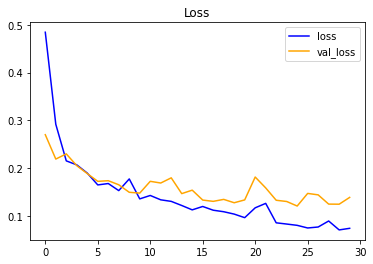

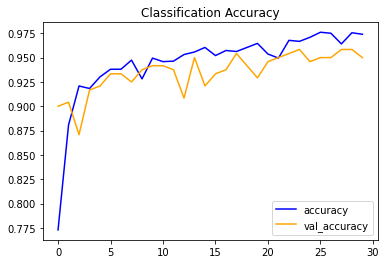

In [14]:
summarize_diagnostics(historyVGG16)

In [15]:
classes = ['Tipo A_ Kunzea', 'Tipo B_ Lepto']

In [16]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=32)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


                precision    recall  f1-score   support

Tipo A_ Kunzea       0.75      0.98      0.85       120
 Tipo B_ Lepto       0.98      0.68      0.80       120

      accuracy                           0.83       240
     macro avg       0.86      0.83      0.83       240
  weighted avg       0.86      0.83      0.83       240

[[118   2]
 [ 39  81]]


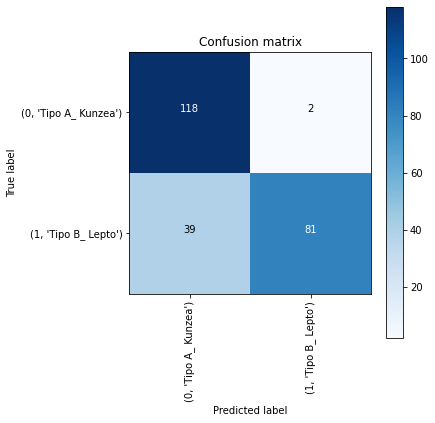

In [17]:
validateResults(modelVGG16)